In [1]:
%matplotlib inline
import cmlreaders as cml
import pandas_to_pybeh as pb
import numpy as np
import seaborn as sns
import pandas as pd

In [2]:
all_fr1_events = cml.CMLReader.load_events(experiments=["FR1"])

In [3]:
events = all_fr1_events.query('type == ["WORD", "REC_WORD"]')
events.rename(columns={'item_name': 'item'}, inplace=True)
events = events[events['list'] > 0]
word_evs = events.query('type == "WORD"')
rec_evs = events.query('type == "REC_WORD"')

#removing subjects who were presented with the same word multiple times (probably repeated data)
n_word_pres = word_evs.groupby(['subject', 'session', 'list', 'item_num']).size().to_frame(name='n').reset_index()
bad_lists = n_word_pres.query('n > 2')
bad_lists[['subject', 'session', 'list']].drop_duplicates()
bad_subs = bad_lists.subject.unique().tolist()
bad_subs = bad_subs + ["R1171M", "R1093J", "R1329T", "R1341T", "R1015J"] #"R1015J" had no recalls, other subjects unsure...
events.query('subject not in @bad_subs', inplace=True)

/home1/evsnyder/.conda/envs/cmlreader0/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [6]:
bad_subs

['R1331T', 'R1396T', 'R1171M', 'R1093J', 'R1329T', 'R1341T', 'R1015J']

In [4]:
pb_crp = events.groupby('subject').apply(pb.pd_crp, 
                                itemno_column='item_num').reset_index()

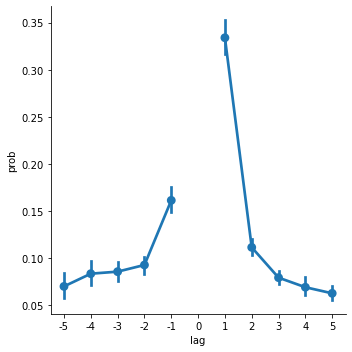

In [5]:
g = sns.catplot(x='lag', y='prob', kind='point', 
                  data=pb_crp.query('lag <= 5 and lag >= -5')
           )

In [11]:
# replace item nums so they are consistent across subjects
item_col = 'item'
item_num_col = 'item_num'
item_num_df = events.query('type == "WORD"').drop_duplicates(subset=item_col, ignore_index=True
                                    )[item_col].reset_index().rename(columns={'index': item_num_col})
events_new = events.merge(item_num_df, on=item_col, suffixes=('', '_new'), 
                          how='left', sort=False)#.sort_values('mstime')
events_new.fillna({'item_num_new': -999}, inplace=True)

In [13]:
import gensim.downloader
word2vec_vectors = gensim.downloader.load('word2vec-google-news-300')

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [14]:
def word_similarity(df, col1, col2, keyed_vector=None):
    try:
        return keyed_vector.similarity(df[col1].lower(), df[col2].lower())
    except:
        return np.nan

In [15]:
# get all pairs of items
items = item_num_df.item.values
sem_sim_df = pd.MultiIndex.from_product([items, items], names=['item_1', 'item_2']).to_frame(index=False)

In [16]:
sem_sim_df

,item_1,item_2
0,BEAR,BEAR
1,BEAR,WING
2,BEAR,DOOR
3,BEAR,PLANT
4,BEAR,ROOT
...,...,...
141371,PLAID,LACE
141372,PLAID,SCARF
141373,PLAID,GIRL
141374,PLAID,GROUND


In [17]:
# compute similarity of all pairs
sem_sim_df['similarity'] = sem_sim_df.apply(word_similarity, 
               axis=1, col1='item_1', 
               col2='item_2', 
               keyed_vector=word2vec_vectors)

In [18]:
sem_sim_num_df = sem_sim_df.merge(
    item_num_df, left_on='item_1', right_on='item').merge(
    item_num_df, left_on='item_2', right_on='item', suffixes=('_1', '_2')).drop(columns=['item_1', 'item_2'])

/home1/rdehaan/.conda/envs/eeg3/lib/python3.7/site-packages/pandas/core/frame.py:9203: FutureWarning: Passing 'suffixes' which cause duplicate columns {'item_1'} in the result is deprecated and will raise a MergeError in a future version.
  validate=validate,


In [19]:
sem_sims = pd.pivot_table(sem_sim_num_df, index='item_num_1', columns='item_num_2', values='similarity', dropna=False)

In [20]:
pb_sem_crp = events_new.groupby('subject').apply(pb.pd_sem_crp, 
                                itemno_column='item_num_new', sem_sims=sem_sims).reset_index()

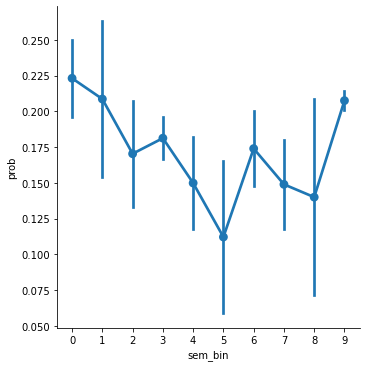

In [21]:
g = sns.catplot(x='sem_bin', y='prob', kind='point', 
                  data=pb_sem_crp
           )

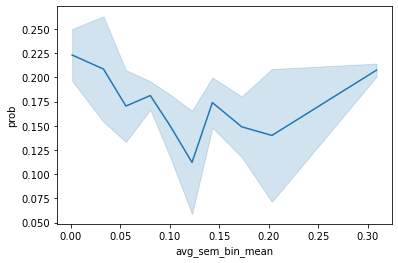

In [22]:
#using average bin value
pb_sem_crp['avg_sem_bin_mean'] = pb_sem_crp.groupby('sem_bin')['sem_bin_mean'].transform('mean')
g = sns.lineplot(x='avg_sem_bin_mean', y='prob', data=pb_sem_crp)

In [31]:
pb_sem_dist_fact = events_new.groupby("subject").apply(pb.pd_dist_fact,
                                                       rec_itemnos=None, 
                                                       itemno_column='item_num_new', 
                                                       list_index=['subject', 'session', 'list'], 
                                                       dist_mat=sem_sims, 
                                                       sim_columns=None, 
                                                       is_similarity=True, 
                                                       dist_columns=None,
                                                       skip_first_n=0,
                                                       pres_type="WORD", rec_type="REC_WORD", type_column='type', ret_counts=False,
                                                       ).reset_index()

pb_sem_dist_fact

,subject,0
0,R1111M,0.490093
1,R1409D,0.405333
